## Spaceship Titanic

PassengerId - 각 승객에 대한 고유한 식별자입니다. 각 식별자는 gggg_pp 형식을 가지며, gggg는 승객이 함께 여행하는 그룹을 나타내고 pp는 그 그룹 내에서의 번호를 나타냅니다. 한 그룹의 사람들은 종종 가족 구성원이지만 항상 그렇지는 않습니다.

HomePlanet - 승객이 출발한 행성으로, 일반적으로 영구 거주지의 행성입니다.

CryoSleep - 승객이 운행 기간 동안 냉동 수면에 들 것인지를 나타냅니다. 냉동 수면에 있는 승객은 자신의 객실로 제한됩니다.

Cabin - 승객이 숙박하는 객실 번호입니다. deck/num/side 형식을 취하며, side는 P(항구) 또는 S(별빛)일 수 있습니다.

Destination - 승객이 하차할 행성입니다.

Age - 승객의 나이입니다.

VIP - 승객이 운항 동안 특별한 VIP 서비스를 구매했는지 여부입니다.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - 승객이 Spaceship Titanic의 여러 고급 편의 시설에서 청구한 금액입니다.

Name - 승객의 이름(이름과 성)입니다.

Transported - 승객이 다른 차원으로 이동되었는지 여부입니다. 이것은 예측하려는 타겟 변수, 즉 예측하려는 열입니다.

In [291]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time
from copy import deepcopy

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder


# models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

## Data
- type
- range
- count
- shape
- null

In [130]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)
print(train.info())
train.head()

(8693, 14)
(4277, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [90]:
target_col = 'Transported'
# num_cols = train.select_dtypes(include=['int64']).columns.tolist()
num_cols = [
    'Age',
    'RoomService',
    'FoodCourt',
    'ShoppingMall',
    'Spa',
    'VRDeck'
    
]
binary_cols = [
    'CryoSleep',
    'VIP',
    'Transported'
]

# cat_cols = test.select_dtypes(include=['object']).columns.tolist()
cat_cols = [
    'HomePlanet',
    'CryoSleep', 
    'Destination',
    'Transported'
]

In [23]:
display(train.corr().style.background_gradient(cmap='Blues').set_caption('train corr'))
display(train.describe().style.background_gradient(cmap='Blues').set_caption('train desc'))
display(train.nunique().to_frame().rename({0:'Unique Value Count'}, axis=1).transpose().style.background_gradient(cmap='Blues').set_caption('train unique'))
display(train.isna().sum().to_frame().transpose().style.background_gradient(cmap='Blues').set_caption('train nan'))

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
Unique Value Count,8693,3,2,6560,3,80,2,1273,1507,1115,1327,1306,8473,2


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0,201,217,199,182,179,203,181,183,208,183,188,200,0


In [24]:
display(test.corr().style.background_gradient(cmap='Blues').set_caption('test corr'))
display(test.describe().style.background_gradient(cmap='Blues').set_caption('test desc'))
display(test.nunique().to_frame().rename({0:'Unique Value Count'}, axis=1).transpose().style.background_gradient(cmap='Blues').set_caption('test unique'))
display(test.isna().sum().to_frame().transpose().style.background_gradient(cmap='Blues').set_caption('test nan'))

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Age,1.000000,0.064097,0.111073,0.039249,0.108344,0.102743
RoomService,0.064097,1.000000,-0.030233,0.064501,0.006342,-0.032827
FoodCourt,0.111073,-0.030233,1.000000,0.027809,0.244851,0.278152
ShoppingMall,0.039249,0.064501,0.027809,1.000000,0.003094,0.029857
Spa,0.108344,0.006342,0.244851,0.003094,1.000000,0.143291
VRDeck,0.102743,-0.032827,0.278152,0.029857,0.143291,1.000000


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
Unique Value Count,4277,3,2,3265,3,79,2,842,902,715,833,796,4176


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0,87,93,100,92,91,93,82,106,98,101,80,94


## EDA
- histogram -> 분포
- heatmap -> 상관관계
- scatter -> 변수간의 관계(선형, 비선형, 이상치), 군집
- dendrogram -> 변수간 유사도
- pie/bar -> 빈도수(범주형)
- boxplot -> 

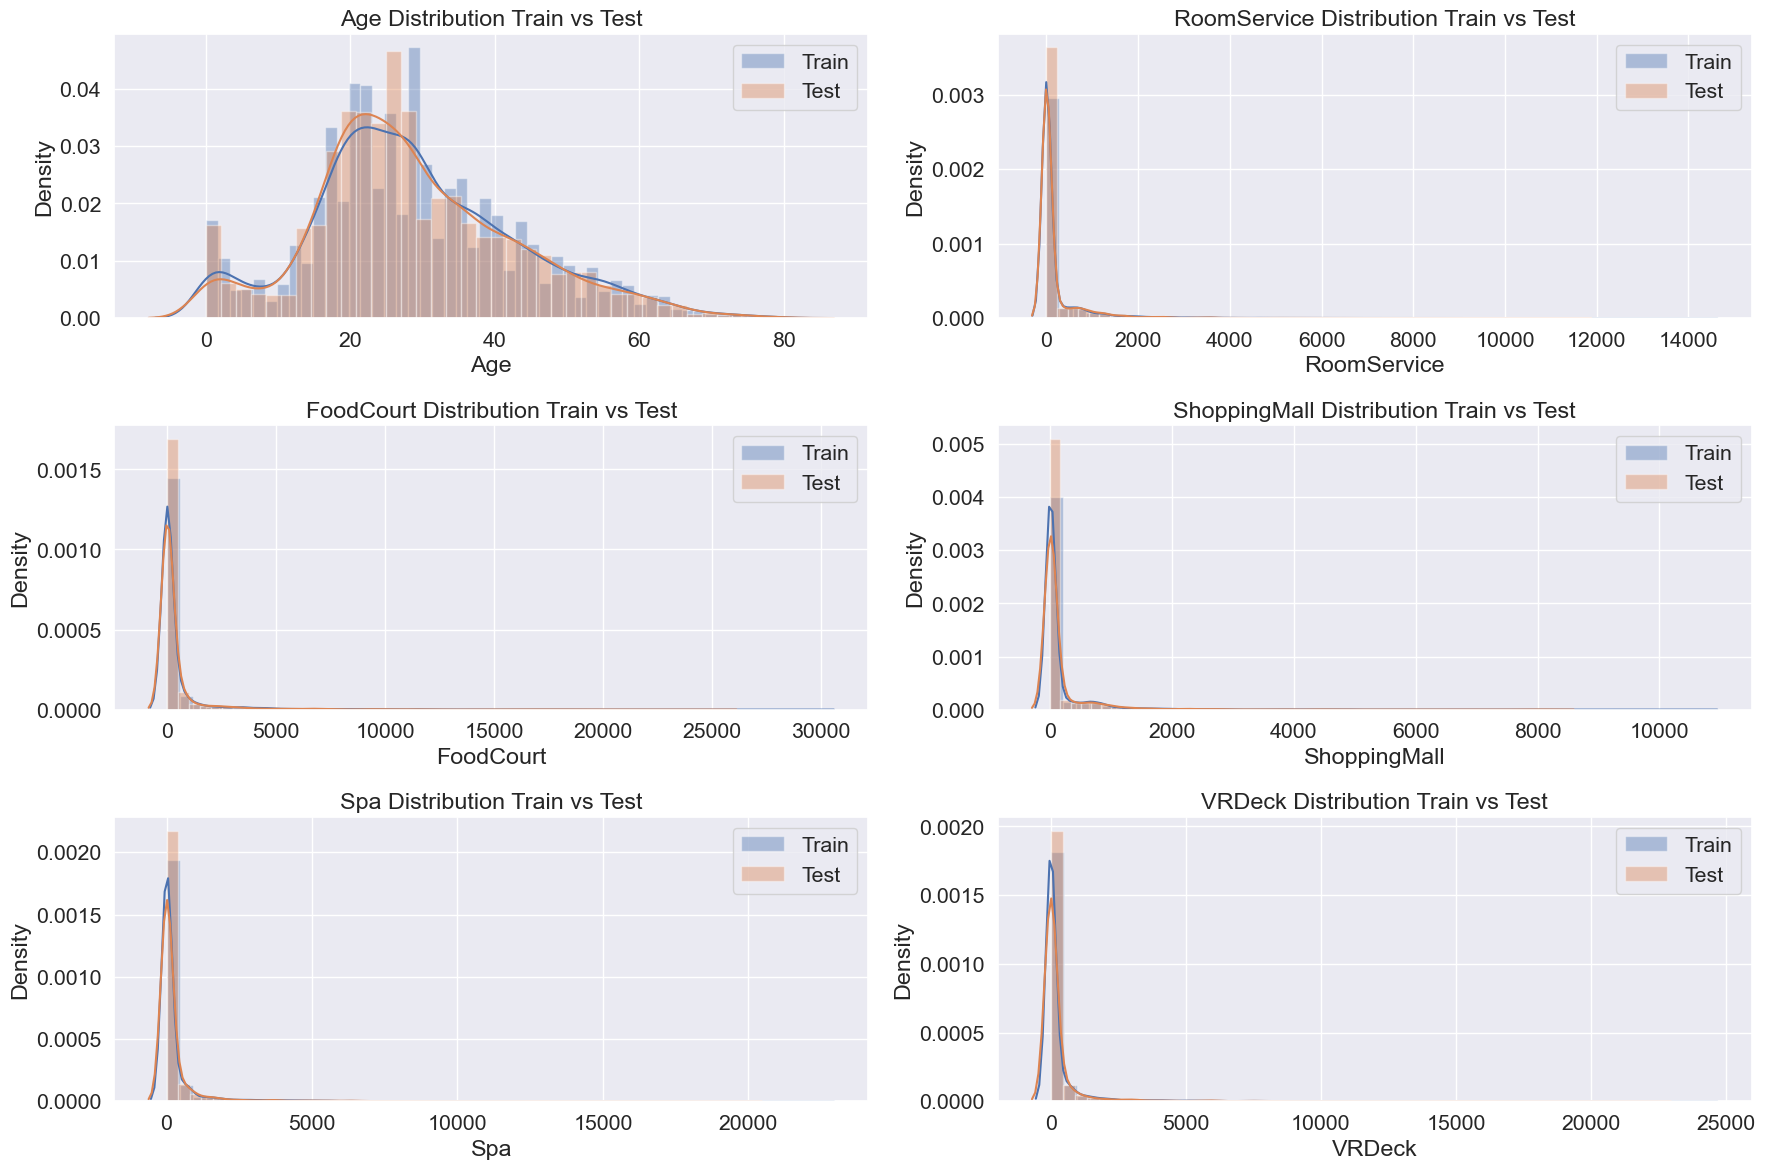

In [155]:
def plot_histogram(df_train, df_test, target_col, n_cols=2):
    n_rows = (len(df_train.columns) - 1) // n_cols + 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()
    
    
    for i, var_name in enumerate(df_train.columns.tolist()):
        ax = axes[i]
        sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
        if var_name != target_col:
            sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')
        ax.set_title(f'{var_name} Distribution Train vs Test')
        ax.legend()
    plt.tight_layout()
    plt.show()
    
plot_histogram(train[num_cols], test[num_cols], target_col)

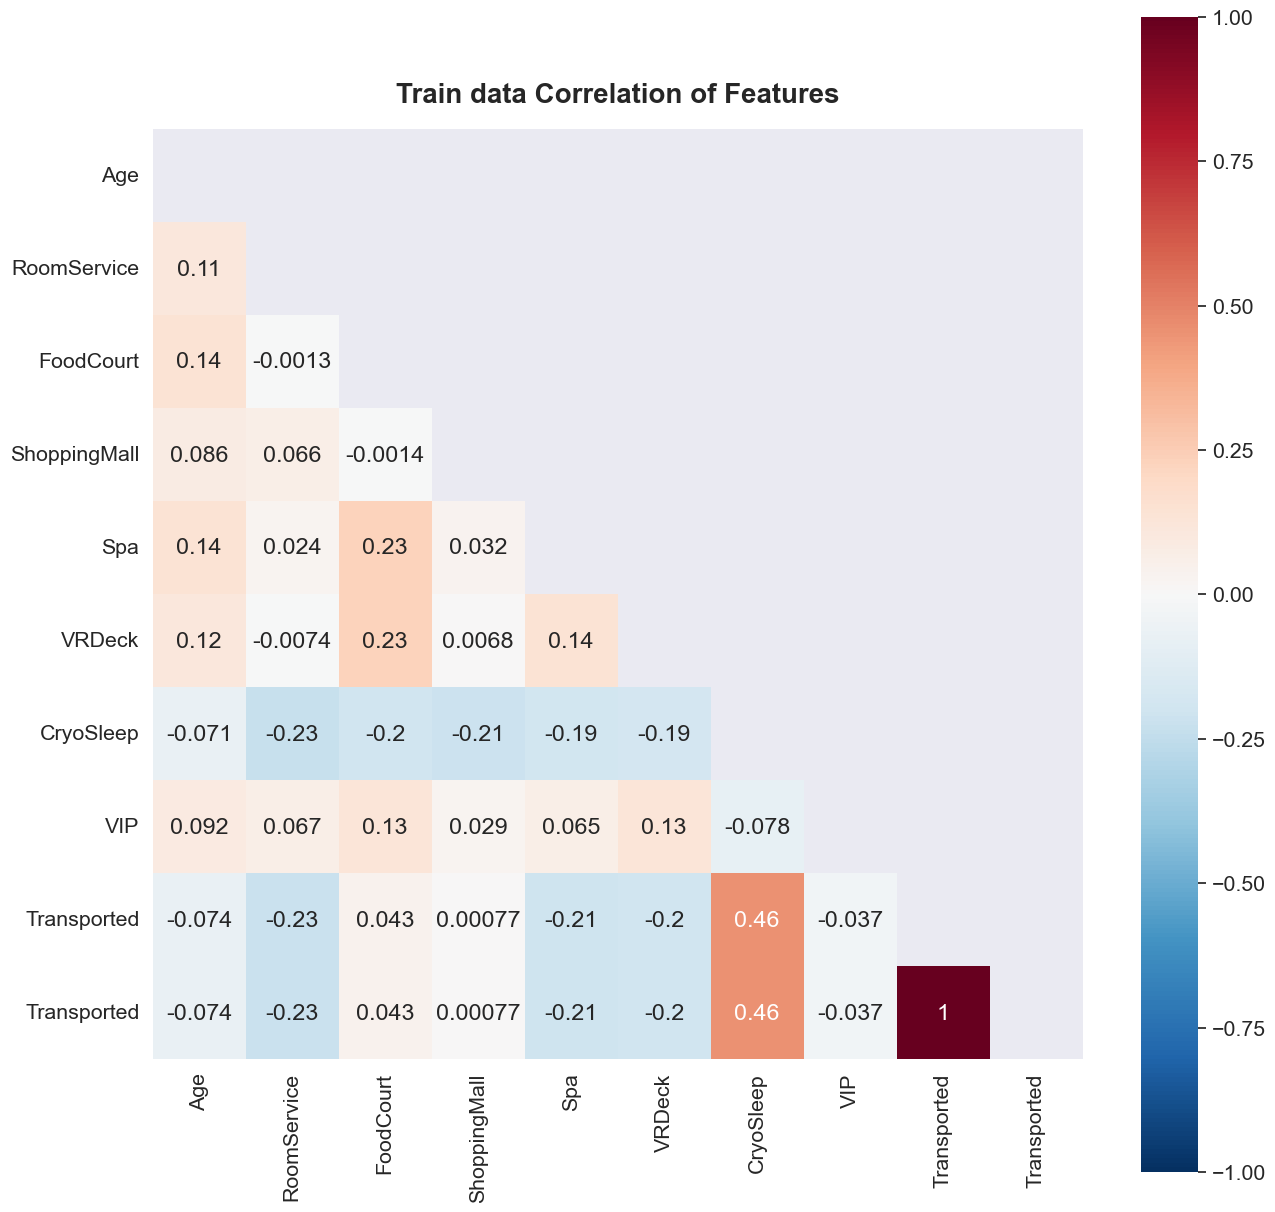

In [145]:
def plot_heatmap(df, title):
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True
    
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(15, 15))
    
    plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=20)
    sns.heatmap(df.astype(float).corr(), cmap=colormap, vmax=1.0, vmin=-1.0, 
                square=True, annot=True, mask=mask)
    
plot_heatmap(train[num_cols+binary_cols+[target_col]], title='Train data')


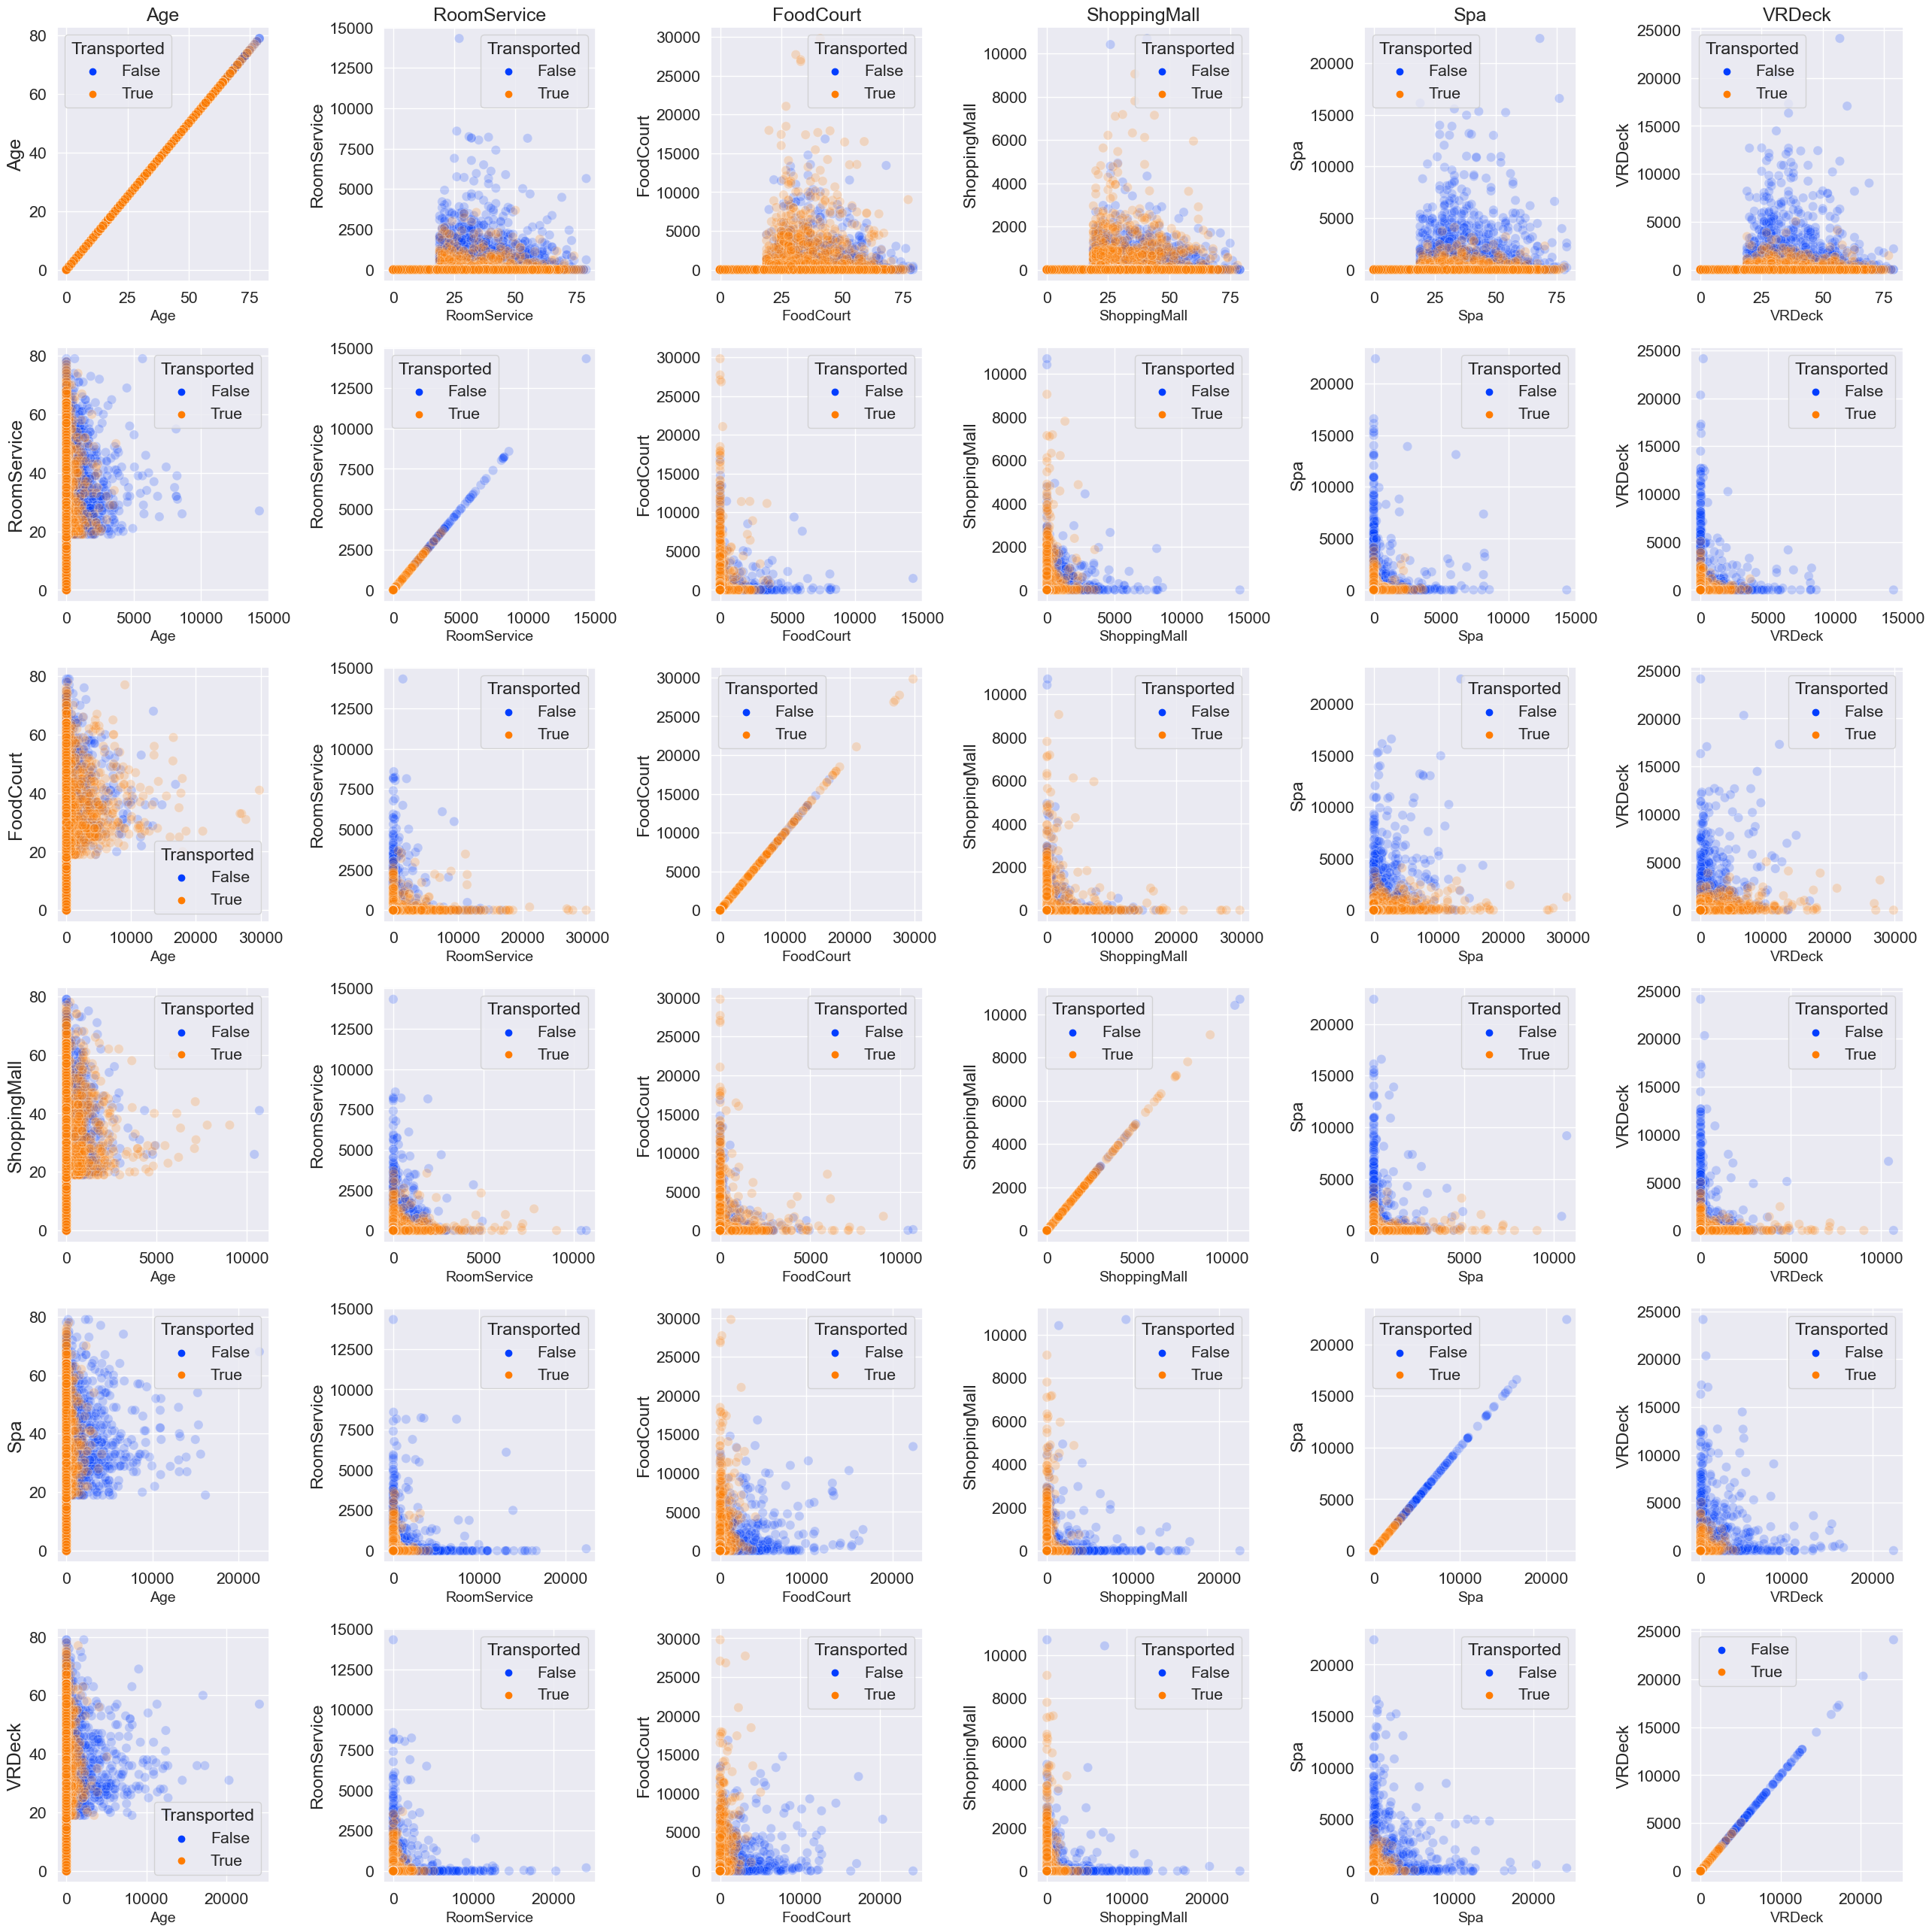

In [146]:
from imblearn.under_sampling import RandomUnderSampler

def plot_scatter_matrix(df, target_col, drop_cols=[], size=26):

    cols = df.columns.drop([target_col] + drop_cols)
    fig, axes = plt.subplots(len(cols), len(cols), figsize=(size, size), sharex=False, sharey=False)
    
    for i, col in enumerate(cols):
        for j, col_ in enumerate(cols):
            axes[i, j].set_xlabel(f'{col}', fontsize=14)
            axes[i, j].set_xlabel(f'{col_}', fontsize=14)            
            
            sns.scatterplot(data=df, x=col, y=col_, hue=target_col, ax=axes[i, j], s=80, alpha=0.2, palette='bright')

            if i == 0:
                axes[i, j].set_title(f'{col_}', fontsize=18)
            if j == 0:
                axes[i, j].set_ylabel(f'{col}', fontsize=18)            
    plt.tight_layout()
    plt.legend()
    plt.show()
    
sampling_strategy = 1.0
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
x_train_res, y_train_res = rus.fit_resample(train.drop(target_col, axis=1), train[target_col])
plot_scatter_matrix(pd.concat([x_train_res[num_cols], y_train_res], axis=1), target_col)

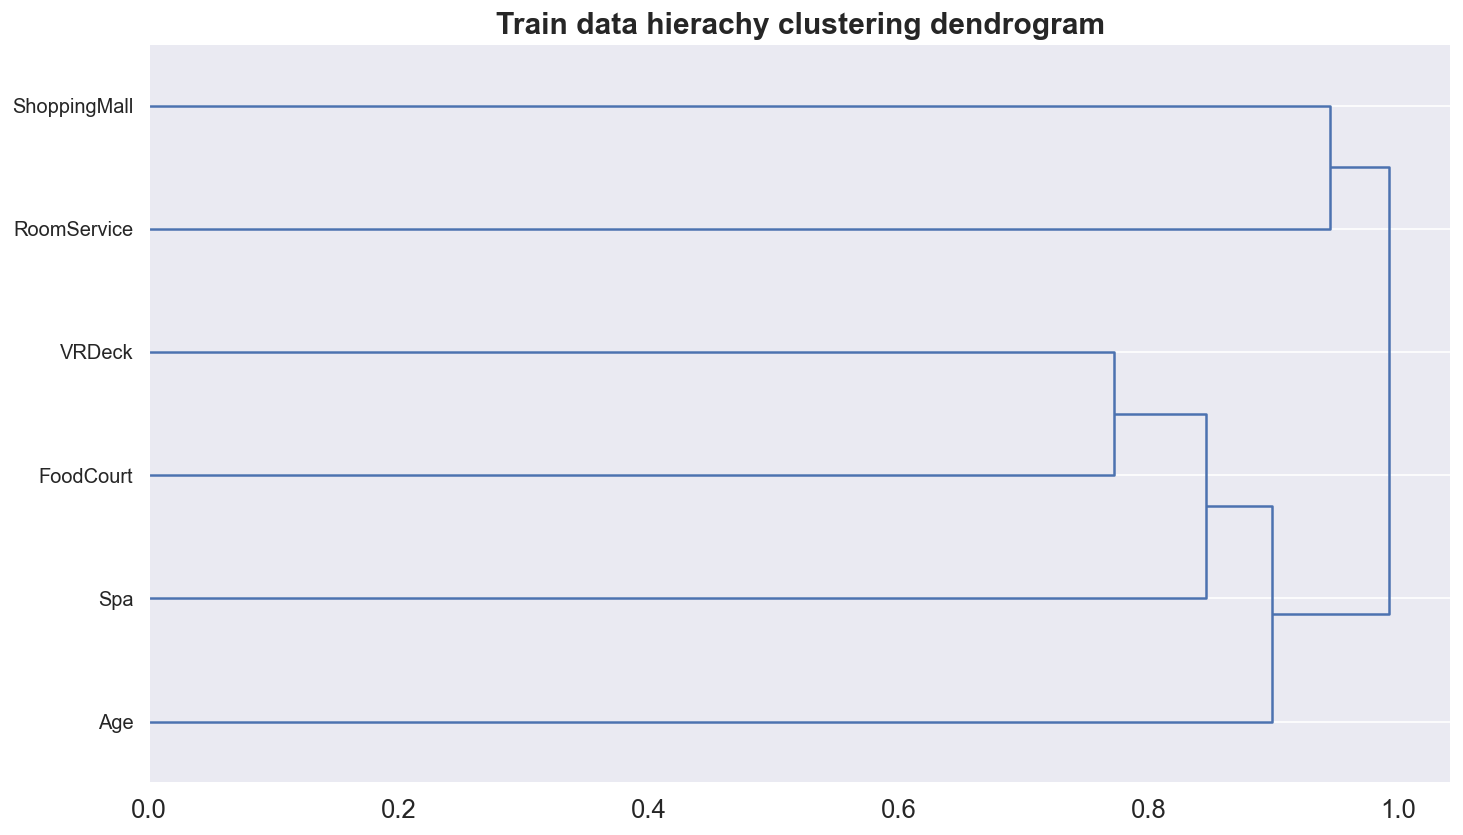

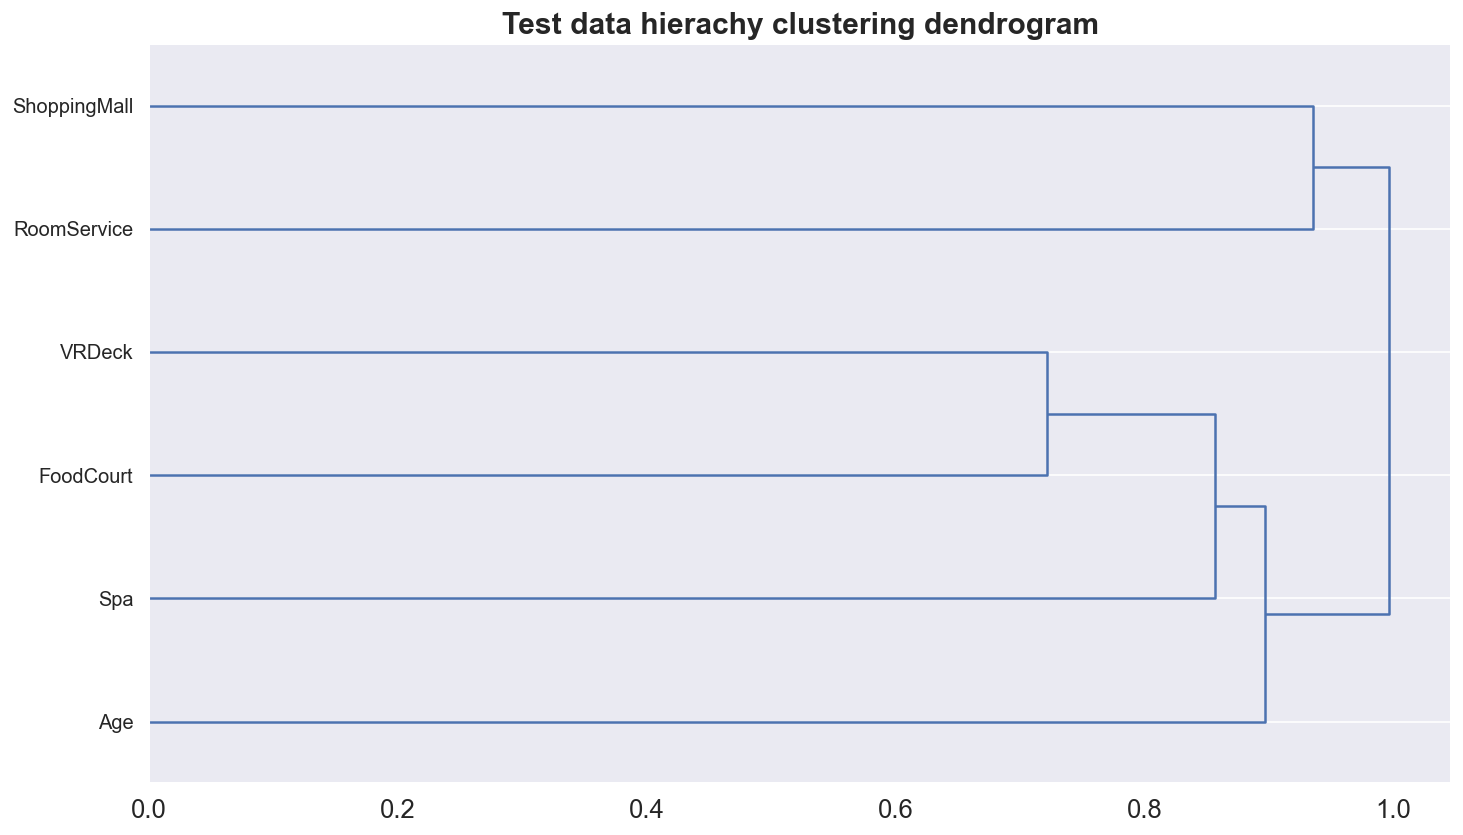

In [79]:
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

def hierarchical_clustering(data, title):
    fig, ax = plt.subplots(1, 1, figsize=(14, 8), dpi=120)
    correlations = data.corr()
    converted_corr = 1 - np.abs(correlations)
    
    Z = linkage(squareform(converted_corr), 'complete')
    dn = dendrogram(Z, labels=data.columns, ax=ax, orientation='right')

    plt.grid(axis='x')
    plt.title(f'{title} hierachy clustering dendrogram', fontsize=18, fontweight='bold')
    plt.show()

hierarchical_clustering(train[num_cols], title='Train data')
hierarchical_clustering(test[num_cols], title='Test data')

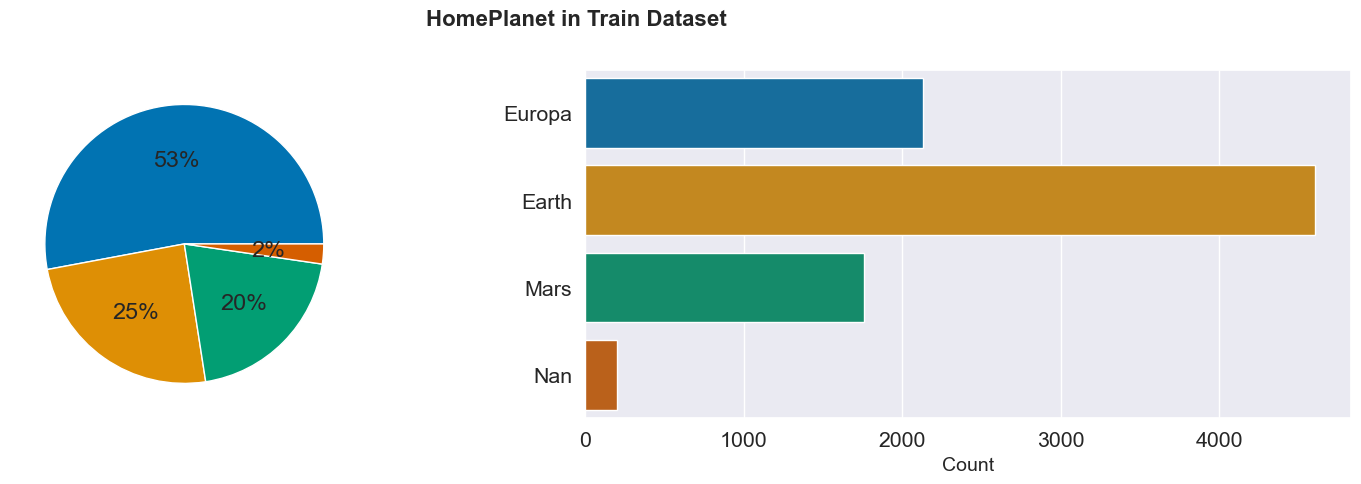

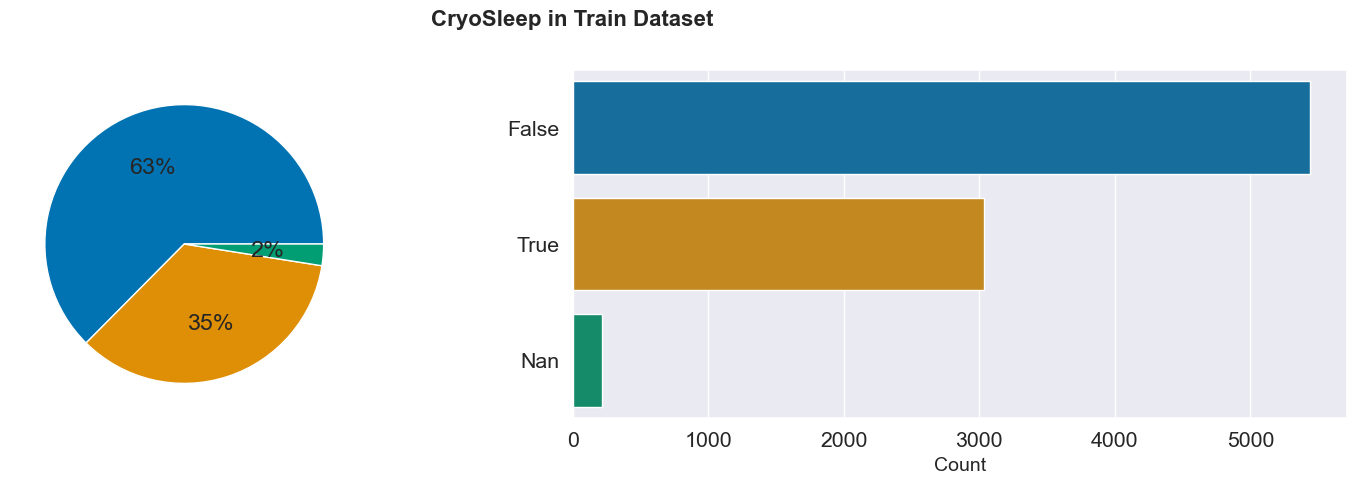

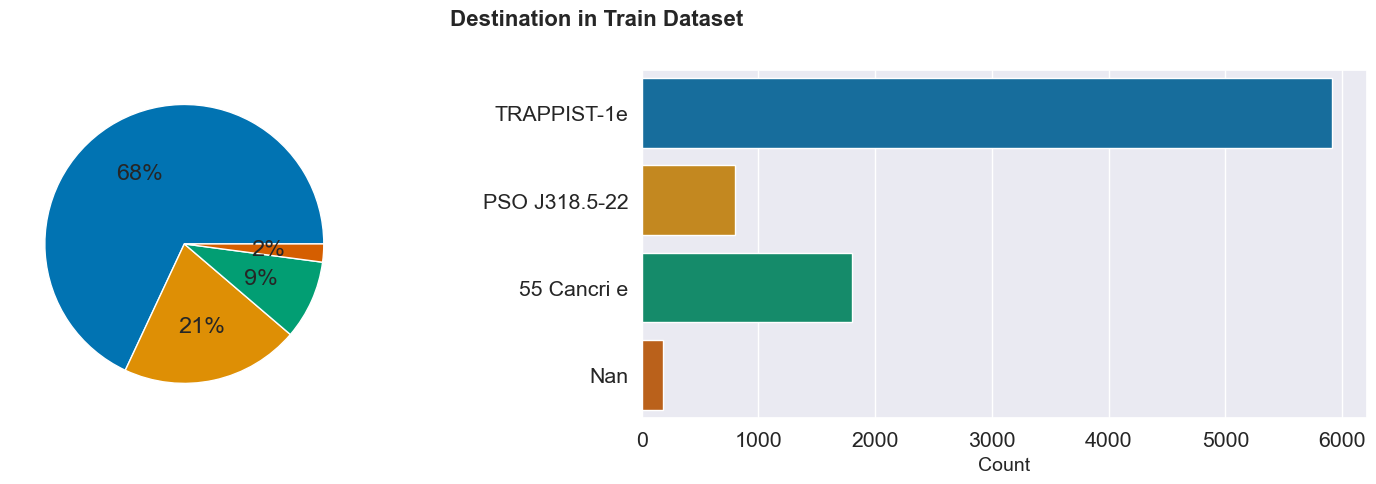

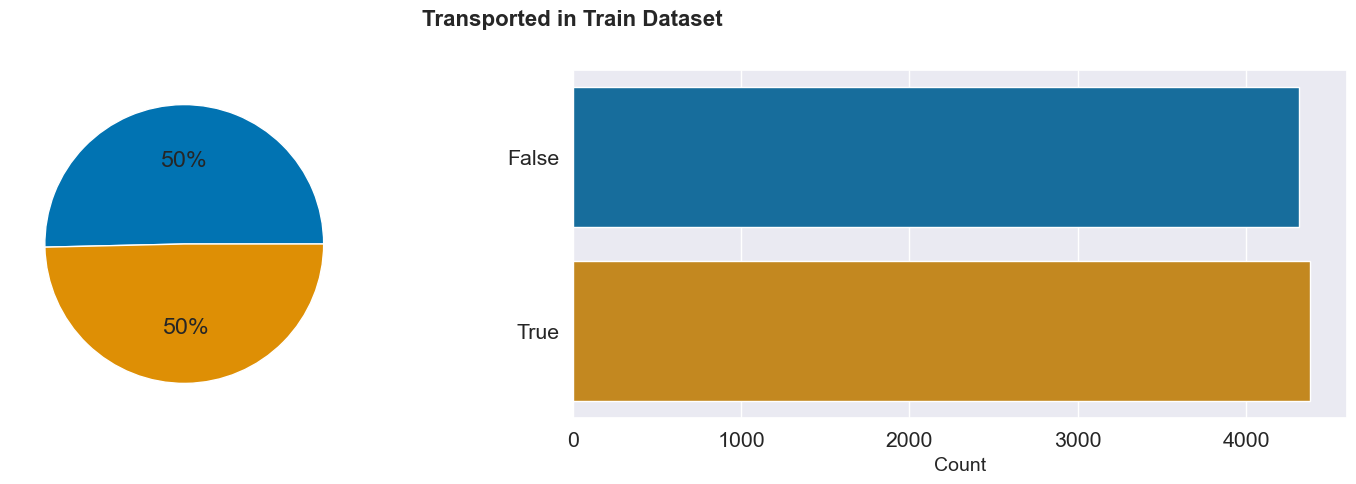

In [93]:
def plot_target_feature(df_train, target_col, title):

    palette='colorblind'
    df_train = df_train.fillna('Nan')
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax = ax.flatten()
    
    # Pie chart
    pie_colors = sns.color_palette(palette, len(df_train[target_col].unique()))
    ax[0].pie(
        df_train[target_col].value_counts(),
        autopct='%1.f%%',
        colors=pie_colors
    )
    ax[0].set_aspect('equal')
    
    # Bar plot
    bar_colors = sns.color_palette(palette)
    sns.countplot(
        data=df_train,
        y=target_col,
        ax=ax[1],
        palette=bar_colors
    )
    ax[1].set_xlabel('Count', fontsize=14)
    ax[1].set_ylabel('')

    fig.suptitle(f'{target_col} in {title} Dataset', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

for f in cat_cols:
    plot_target_feature(train, f, 'Train')

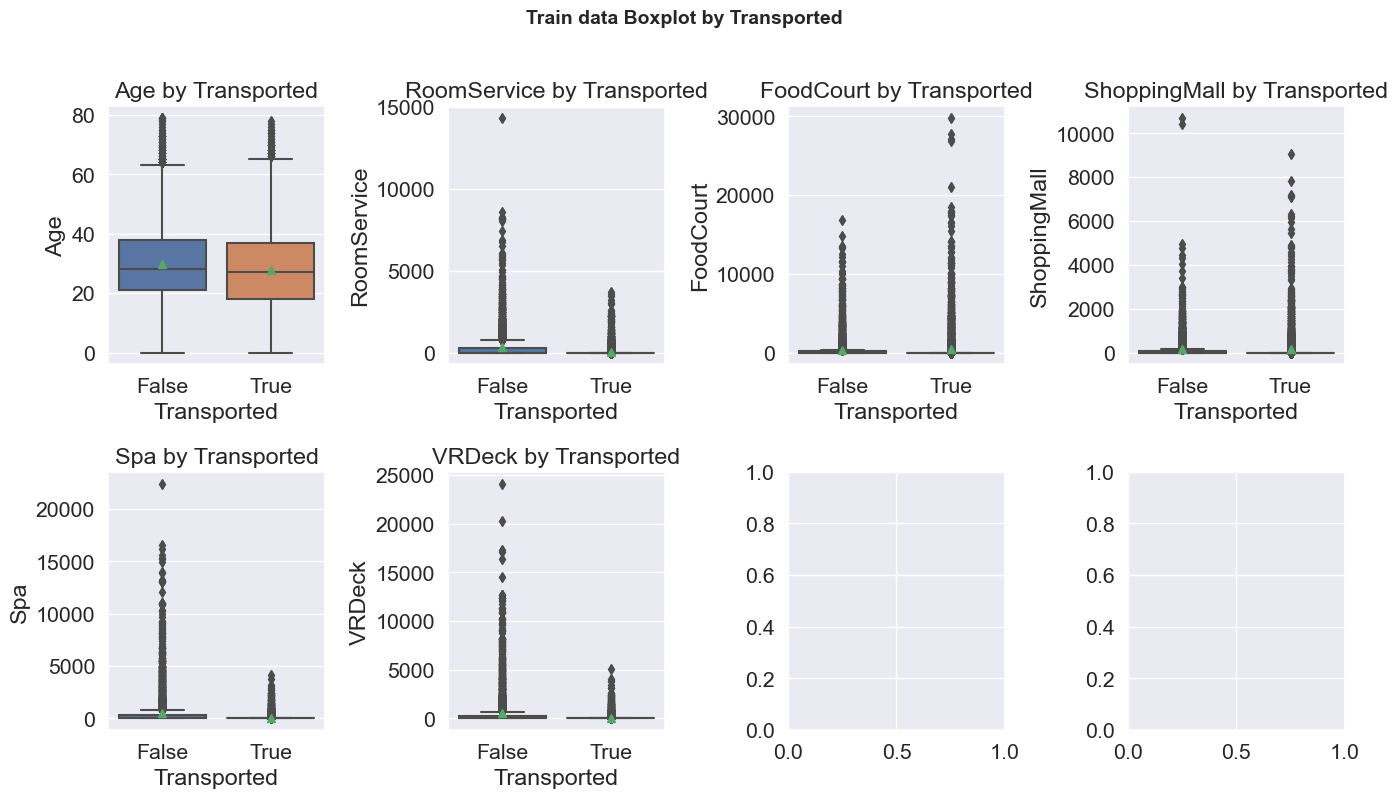

In [151]:
def plot_boxplot(df, hue, drop_cols=[], n_cols=3, title=''):
    cols = df.columns.drop([hue] + drop_cols)
    n_rows = (len(cols) - 1) // n_cols + 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))
    
    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols
        
        ax = axes[row, col]
        sns.boxplot(data=df, x=hue, y= var_name, ax=ax, showmeans=True)
        ax.set_title(f'{var_name} by {hue}')
    fig.suptitle(f'{title} Boxplot by {hue}', fontweight='bold', fontsize=14, y=1.005)
    plt.tight_layout()
    plt.show()
    
plot_boxplot(train[num_cols+[target_col]], hue=target_col, n_cols=4, title='Train data')

## Feature Engineering
- encoding
    - label encoding
    - onehot encodin(0, 1)
- create new feature
- add pca feature

In [129]:
def create_features(df):
    # Age
    age_limit = 19
    df['AgeGroup'] = np.where(df['Age'] < age_limit, 0, 1)
    
    df['Total_Billed'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    df['No_spending']=(df['Total_Billed']==0).astype(int)
    
    df['CabinDeck'] = df['Cabin'].str.split('/', expand=True)[0]
    df['CabinNum']  = df['Cabin'].str.split('/', expand=True)[1]
    df['CabinSide'] = df['Cabin'].str.split('/', expand=True)[2]
    
    df['FirstName'] = df['Name'].str.split(' ', expand=True)[0]
    df['FamilyName'] = df['Name'].str.split(' ', expand=True)[1]
#     df['FamilySize'] = df['FamilyName'].value_counts()
    
    df['Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
    df['Group_size'] = df['Group'].value_counts()
    df['Solo']=(df['Group_size']==1).astype(int)
    
    df.drop(columns = ['Cabin'], inplace = True)

In [131]:
create_features(train)
create_features(test)

In [132]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Total_Billed,No_spending,CabinDeck,CabinNum,CabinSide,FirstName,FamilyName,Group,Group_size,Solo
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,0.0,1,B,0,P,Maham,Ofracculy,1,NaN,0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,736.0,0,F,0,S,Juanna,Vines,2,1.0,1
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,10383.0,0,A,0,S,Altark,Susent,3,1.0,1
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,5176.0,0,A,0,S,Solam,Susent,3,2.0,0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,1091.0,0,F,1,S,Willy,Santantines,4,1.0,1


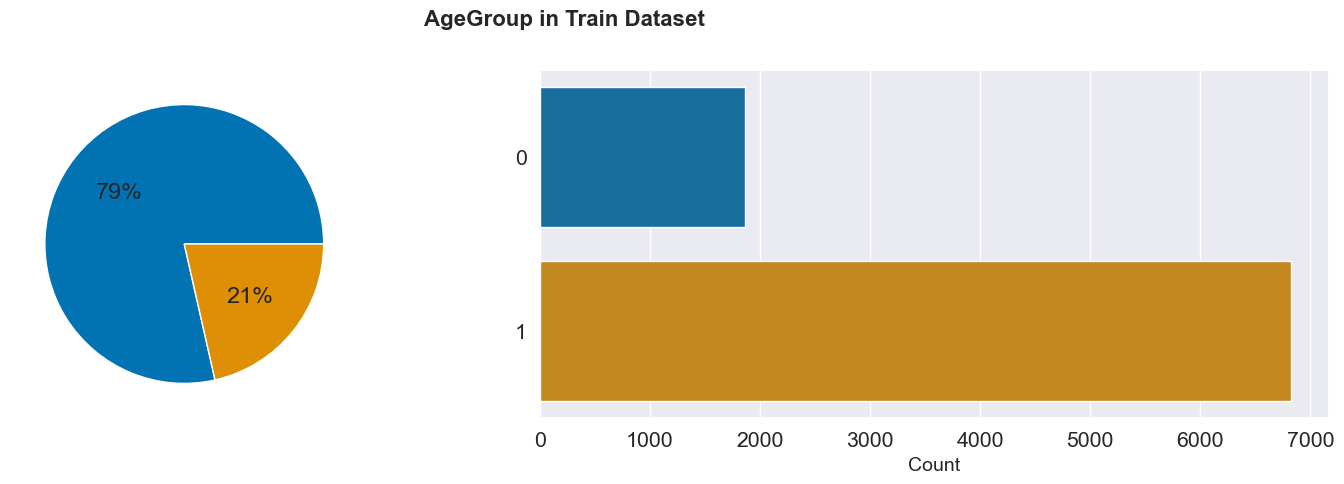

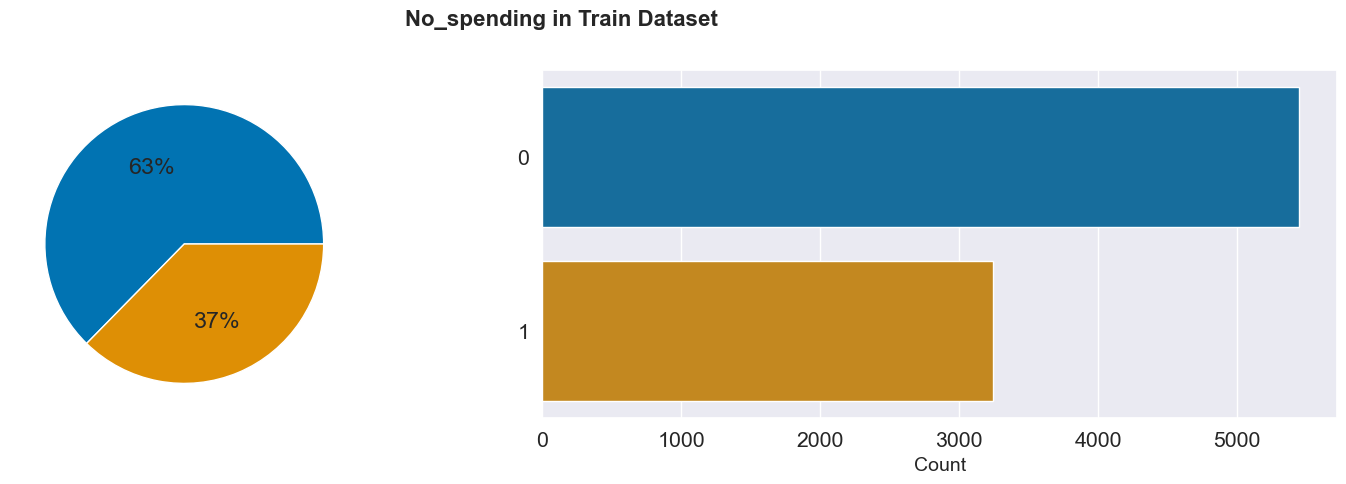

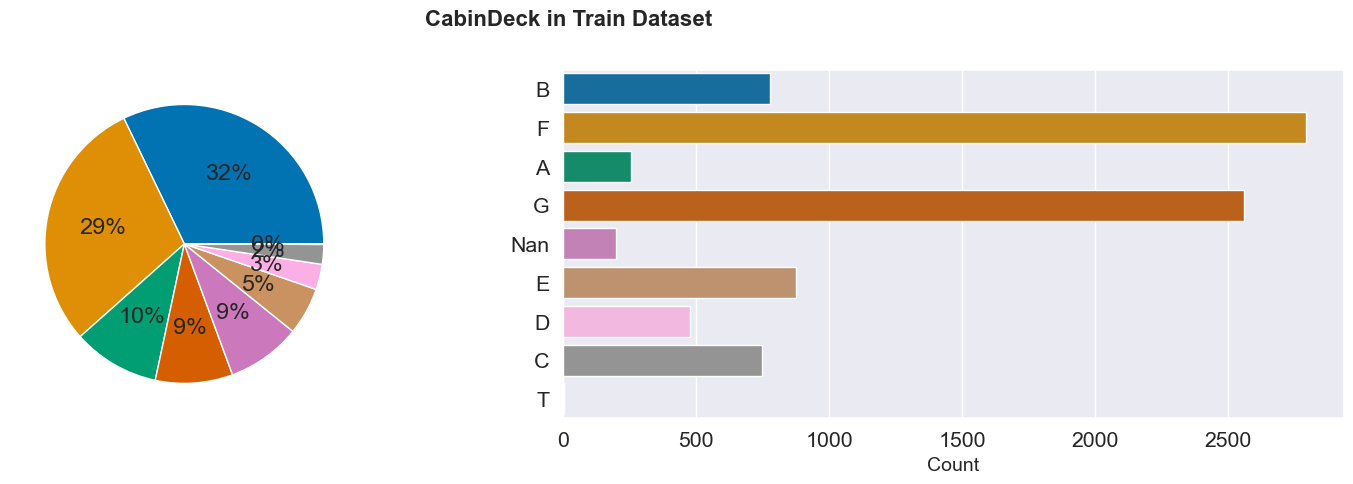

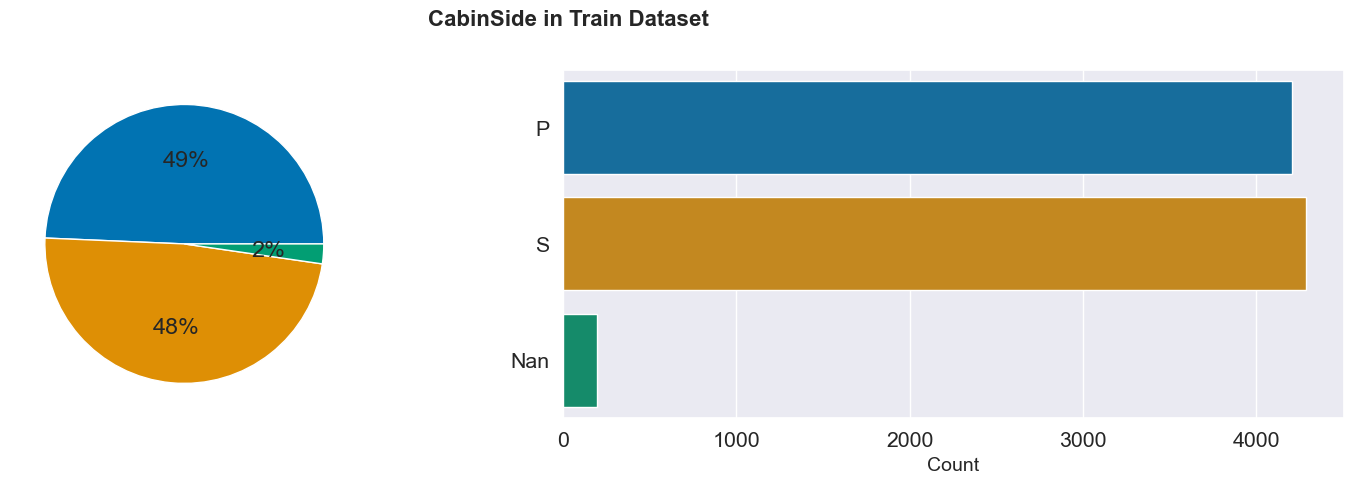

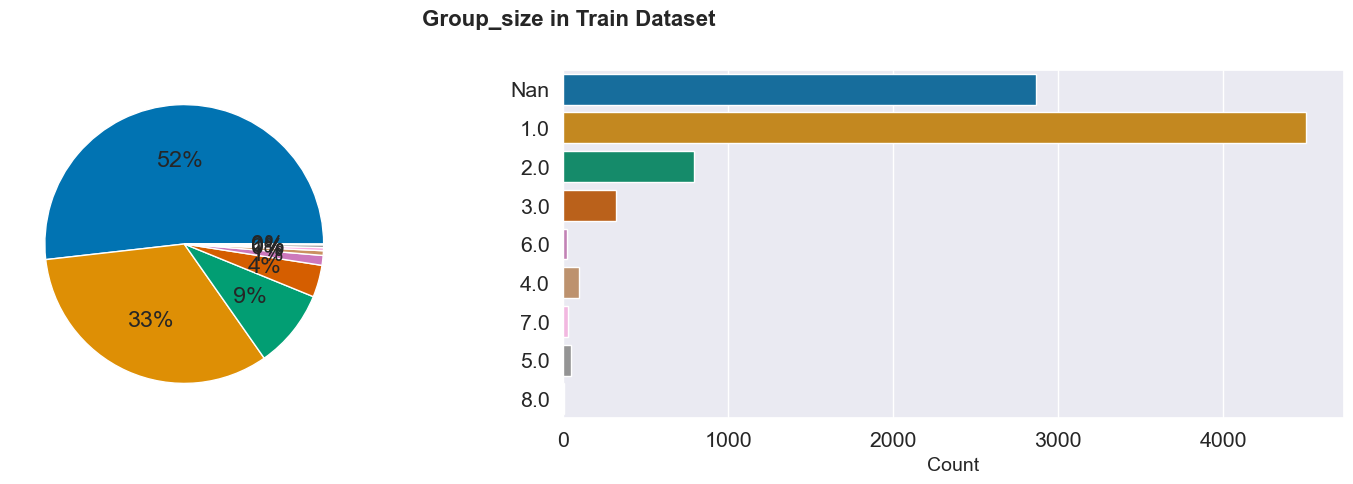

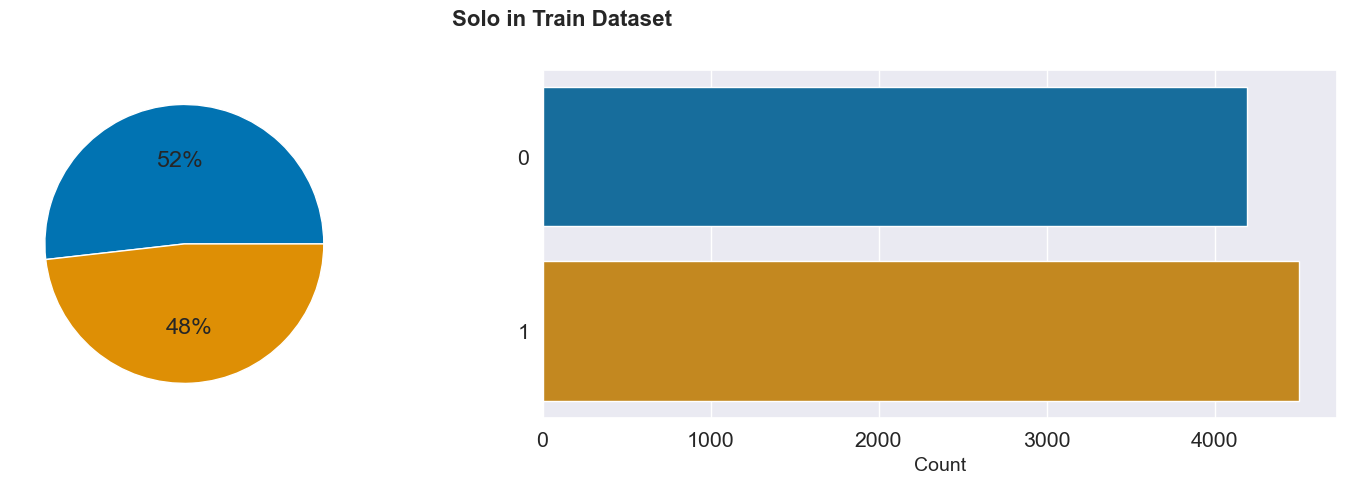

In [109]:
cat_cols2 = [
    'AgeGroup',
    'No_spending',
    'CabinDeck',
    'CabinSide',
    'Group_size',
    'Solo'
]
for f in cat_cols2:
    plot_target_feature(train, f, 'Train')

In [124]:
display(train.corr().style.background_gradient(cmap='Blues').set_caption('train corr'))
display(train.describe().style.background_gradient(cmap='Blues').set_caption('train desc'))
display(train.nunique().to_frame().rename({0:'Unique Value Count'}, axis=1).transpose().style.background_gradient(cmap='Blues').set_caption('train unique'))
display(train.isna().sum().to_frame().transpose().style.background_gradient(cmap='Blues').set_caption('train nan'))

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,AgeGroup,Total_Billed,No_spending,FamilySize,Group,Group_size,Solo
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026,0.651447,0.189475,-0.210887,nan,-0.009439,0.039822,-0.017311
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611,0.077427,0.235768,-0.264670,nan,-0.000346,0.000820,-0.001319
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566,0.117468,0.747214,-0.223286,nan,-0.009552,-0.019183,0.013255
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141,0.045171,0.224083,-0.226214,nan,0.017397,-0.009412,0.002001
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131,0.096537,0.597796,-0.215009,nan,-0.005211,0.006143,0.003482
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075,0.100460,0.573186,-0.209109,nan,0.015432,-0.028388,0.017533
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000,-0.108587,-0.197671,0.432689,nan,0.021491,0.020074,-0.005209
AgeGroup,0.651447,0.077427,0.117468,0.045171,0.096537,0.100460,-0.108587,1.000000,0.173315,-0.267861,nan,-0.002326,0.006811,0.003848
Total_Billed,0.189475,0.235768,0.747214,0.224083,0.597796,0.573186,-0.197671,0.173315,1.000000,-0.441388,nan,-0.001793,-0.016398,0.014482
No_spending,-0.210887,-0.264670,-0.223286,-0.226214,-0.215009,-0.209109,0.432689,-0.267861,-0.441388,1.000000,nan,-0.001315,-0.017016,0.002102


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,AgeGroup,Total_Billed,No_spending,FamilySize,Group,Group_size,Solo
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000,7785.000000,8693.000000,0.000000,8693.000000,5830.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,0.785460,1484.601541,0.373519,nan,4633.389624,1.395369,0.517888
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.410527,2845.288241,0.483766,nan,2671.028856,0.928354,0.499709
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,nan,1.000000,1.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,nan,2319.000000,1.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,736.000000,0.000000,nan,4630.000000,1.000000,1.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000,1486.000000,1.000000,nan,6883.000000,1.000000,1.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000,35987.000000,1.000000,nan,9280.000000,8.000000,1.000000


,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,AgeGroup,Total_Billed,No_spending,CabinDeck,CabinNum,CabinSide,FirstName,FamilyName,FamilySize,Group,Group_size,Solo
Unique Value Count,8693,3,2,3,80,2,1273,1507,1115,1327,1306,8473,2,2,2116,2,8,1817,2,2706,2217,0,6217,8,2


,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,AgeGroup,Total_Billed,No_spending,CabinDeck,CabinNum,CabinSide,FirstName,FamilyName,FamilySize,Group,Group_size,Solo
0,0,201,217,182,179,203,181,183,208,183,188,200,0,0,908,0,199,199,199,200,200,8693,0,2863,0


In [ ]:
def add_pca_features():
    

In [110]:
from category_encoders import OrdinalEncoder, CountEncoder, CatBoostEncoder, OneHotEncoder

def cat_encoding(df_train, df_test, cat_cols, encode='label'):
    if encode == 'label':
        encoder = OrdinalEncoder(cols=cat_cols)
        train_encoder = encoder.fit_transform(df_train[cat_cols]).astype(int)
        test_encoder = encoder.transform(df_test[cat_cols]).astype(int)
        df_train[cat_cols] = train_encoder[cat_cols]
        df_test[cat_cols] = test_encoder[cat_cols]
        encoder_cols = cat_cols
    else: # onehot
        encoder = OneHotEncoder(handle_unknown='ignore')
        train_encoder = encoder.fit_transform(df_train[cat_cols]).astype(int)
        test_encoder = encoder.transform(df_test[cat_cols]).astype(int)
        df_train = pd.concat([df_train, train_encoder], axis=1)
        df_test = pd.concat([df_test, test_encoder], axis=1)
        df_train.drop(cat_cols, axis=1, inplace=True)
        df_test.drop(cat_cols, axis=1, inplace=True)
        encoder_cols = list(train_encoder.columns)
        
    return df_train, df_test, encoder_cols

In [114]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Total_Billed,No_spending,CabinDeck,CabinNum,CabinSide,FirstName,FamilyName,Group,Group_size,Solo
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,0.0,1,B,0,P,Maham,Ofracculy,1,NaN,0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,736.0,0,F,0,S,Juanna,Vines,2,1.0,1
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,10383.0,0,A,0,S,Altark,Susent,3,1.0,1
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,5176.0,0,A,0,S,Solam,Susent,3,2.0,0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,1091.0,0,F,1,S,Willy,Santantines,4,1.0,1


In [260]:
cat_encoding(train, test, 'CabinDeck')

(     PassengerId  HomePlanet  CryoSleep  Destination   Age  VIP  RoomService  \
 0        0001_01           1          0            1  39.0    0          0.0   
 1        0002_01           2          0            1  24.0    0        109.0   
 2        0003_01           1          0            1  58.0    1         43.0   
 3        0003_02           1          0            1  33.0    0          0.0   
 4        0004_01           2          0            1  16.0    0          0.0   
 ...          ...         ...        ...          ...   ...  ...          ...   
 8688     9276_01           1          0            3  41.0    1          0.0   
 8689     9278_01           2          1            2  18.0    0          0.0   
 8690     9279_01           2          0            1  26.0    0          0.0   
 8691     9280_01           1          0            3  32.0    0          0.0   
 8692     9280_02           1          0            1  44.0    0        126.0   
 
       FoodCourt  Shopping

In [254]:
cat_encoding(train, test, 'Destination')

(     PassengerId HomePlanet  CryoSleep  Destination   Age  VIP  RoomService  \
 0        0001_01     Europa          0            1  39.0    0          0.0   
 1        0002_01      Earth          0            1  24.0    0        109.0   
 2        0003_01     Europa          0            1  58.0    1         43.0   
 3        0003_02     Europa          0            1  33.0    0          0.0   
 4        0004_01      Earth          0            1  16.0    0          0.0   
 ...          ...        ...        ...          ...   ...  ...          ...   
 8688     9276_01     Europa          0            3  41.0    1          0.0   
 8689     9278_01      Earth          1            2  18.0    0          0.0   
 8690     9279_01      Earth          0            1  26.0    0          0.0   
 8691     9280_01     Europa          0            3  32.0    0          0.0   
 8692     9280_02     Europa          0            1  44.0    0        126.0   
 
       FoodCourt  ShoppingMall     Spa

In [256]:
cat_encoding(train, test, 'HomePlanet')

(     PassengerId  HomePlanet  CryoSleep  Destination   Age  VIP  RoomService  \
 0        0001_01           1          0            1  39.0    0          0.0   
 1        0002_01           2          0            1  24.0    0        109.0   
 2        0003_01           1          0            1  58.0    1         43.0   
 3        0003_02           1          0            1  33.0    0          0.0   
 4        0004_01           2          0            1  16.0    0          0.0   
 ...          ...         ...        ...          ...   ...  ...          ...   
 8688     9276_01           1          0            3  41.0    1          0.0   
 8689     9278_01           2          1            2  18.0    0          0.0   
 8690     9279_01           2          0            1  26.0    0          0.0   
 8691     9280_01           1          0            3  32.0    0          0.0   
 8692     9280_02           1          0            1  44.0    0        126.0   
 
       FoodCourt  Shopping

In [261]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Total_Billed,No_spending,CabinDeck,CabinNum,CabinSide,FirstName,FamilyName,Group,Group_size,Solo
0,0001_01,1,0,1,39.0,0,0.0,0.0,0.0,0.0,...,0.0,1,1,0,1,Maham,Ofracculy,1,1.395369,0
1,0002_01,2,0,1,24.0,0,109.0,9.0,25.0,549.0,...,736.0,0,2,0,2,Juanna,Vines,2,1.000000,1
2,0003_01,1,0,1,58.0,1,43.0,3576.0,0.0,6715.0,...,10383.0,0,3,0,2,Altark,Susent,3,1.000000,1
3,0003_02,1,0,1,33.0,0,0.0,1283.0,371.0,3329.0,...,5176.0,0,3,0,2,Solam,Susent,3,2.000000,0
4,0004_01,2,0,1,16.0,0,0.0,0.0,0.0,0.0,...,1091.0,0,2,1,2,Willy,Santantines,4,1.000000,1


In [259]:
cat_encoding(train, test, 'CabinSide')

(     PassengerId  HomePlanet  CryoSleep  Destination   Age  VIP  RoomService  \
 0        0001_01           1          0            1  39.0    0          0.0   
 1        0002_01           2          0            1  24.0    0        109.0   
 2        0003_01           1          0            1  58.0    1         43.0   
 3        0003_02           1          0            1  33.0    0          0.0   
 4        0004_01           2          0            1  16.0    0          0.0   
 ...          ...         ...        ...          ...   ...  ...          ...   
 8688     9276_01           1          0            3  41.0    1          0.0   
 8689     9278_01           2          1            2  18.0    0          0.0   
 8690     9279_01           2          0            1  26.0    0          0.0   
 8691     9280_01           1          0            3  32.0    0          0.0   
 8692     9280_02           1          0            1  44.0    0        126.0   
 
       FoodCourt  Shopping

In [280]:
'''
True/False -> 1/0
'''
train['CryoSleep'] = train['CryoSleep'].astype(int)
train['VIP'] = train['VIP'].astype(int)
train['Transported'] = train['Transported'].astype(int)
train['CabinNum'] = train['CabinNum'].astype(int)


test['CryoSleep'] = test['CryoSleep'].astype(int)
test['VIP'] = test['VIP'].astype(int)
test['CabinNum'] = test['CabinNum'].astype(int)


## Missing Value

In [262]:
na_cols = train.columns[train.isna().any()].tolist()
na_cols

[]

In [135]:
mv=pd.DataFrame(train[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(train),2)
mv

,Number_missing,Percentage_missing
HomePlanet,201,2.31
CryoSleep,217,2.50
Destination,182,2.09
Age,179,2.06
VIP,203,2.34
RoomService,181,2.08
FoodCourt,183,2.11
ShoppingMall,208,2.39
Spa,183,2.11
VRDeck,188,2.16


In [138]:
'''
미성년자는 유료 서비스를 구매하지 않았을 것이라 예상
'''
def fill_nans_by_age(df, age_limit=19):
    df['RoomService'] = np.where(df['Age'] < age_limit, 0, df['RoomService'])
    df['FoodCourt'] = np.where(df['Age'] < age_limit, 0, df['FoodCourt'])
    df['ShoppingMall'] = np.where(df['Age'] < age_limit, 0, df['ShoppingMall'])
    df['Spa'] = np.where(df['Age'] < age_limit, 0, df['Spa'])
    df['VRDeck'] = np.where(df['Age'] < age_limit, 0, df['VRDeck'])
    return df

'''
냉동 수면을 신청한 경우 유료 서비스를 구매하지 않았을 것이라 예상
'''
def fill_nans_cryo(df):
    df['RoomService'] = np.where(df['CryoSleep'] == True, 0, df['RoomService'])
    df['FoodCourt'] = np.where(df['CryoSleep'] == True, 0, df['FoodCourt'])
    df['ShoppingMall'] = np.where(df['CryoSleep'] == True, 0, df['ShoppingMall'])
    df['Spa'] = np.where(df['CryoSleep'] == True, 0, df['Spa'])
    df['VRDeck'] = np.where(df['CryoSleep'] == True, 0, df['VRDeck'])
    return df

'''
수치형 데이터는 평균으로 맞추고 범주형 데이터는 최빈값으로 맞춤
'''
def fill_missing(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    numeric_tmp = df.select_dtypes(include = numerics)
    categ_tmp = df.select_dtypes(exclude = numerics)

    for col in numeric_tmp.columns:
        df[col] = df[col].fillna(value = df[col].mean())
        
    for col in categ_tmp.columns:
        df[col] = df[col].fillna(value = df[col].mode()[0])
    return df 

In [139]:
train = fill_nans_by_age(train)
train = fill_nans_cryo(train)
train = fill_missing(train)

In [141]:
test = fill_nans_by_age(test)
test = fill_nans_cryo(test)
test = fill_missing(test)

In [263]:
# train.isna().sum()
test.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
AgeGroup        0
Total_Billed    0
No_spending     0
CabinDeck       0
CabinNum        0
CabinSide       0
FirstName       0
FamilyName      0
Group           0
Group_size      0
Solo            0
dtype: int64

## Outliers

In [ ]:
from scipy import stats
import numpy as np

# # 데이터 X에 대한 Z-Score 계산
# z_scores = np.abs(stats.zscore(X))

# # 이상치 탐지를 위한 임계값 설정
# threshold = 3

# # 이상치 탐지
# outlier_indices = np.where(z_scores > threshold)[0]

Q1 = np.percentile(X, 25)
Q3 = np.percentile(X, 75)
IQR = Q3 - Q1

# 이상치 탐지를 위한 임계값 설정 (주로 1.5 또는 3을 사용)
threshold = 1.5 * IQR

# 이상치 탐지
lower_bound = Q1 - threshold
upper_bound = Q3 + threshold
outlier_indices = np.where((X < lower_bound) | (X > upper_bound))[0]

## Data Scaling

In [307]:
from sklearn.preprocessing import StandardScaler


x_train = train.copy()
x_test = test.copy()

# StandardScaler
sc = StandardScaler() # MinMaxScaler or StandardScaler
numerical_cols = [cname for cname in train.columns if train[cname].dtype in ['int64', 'float64']]
x_train[numerical_cols] = sc.fit_transform(x_train[numerical_cols])
x_test[numerical_cols] = sc.transform(x_test[numerical_cols])


# Print new shape
print('Training set shape:', x_train.shape)

Training set shape: (8693, 24)


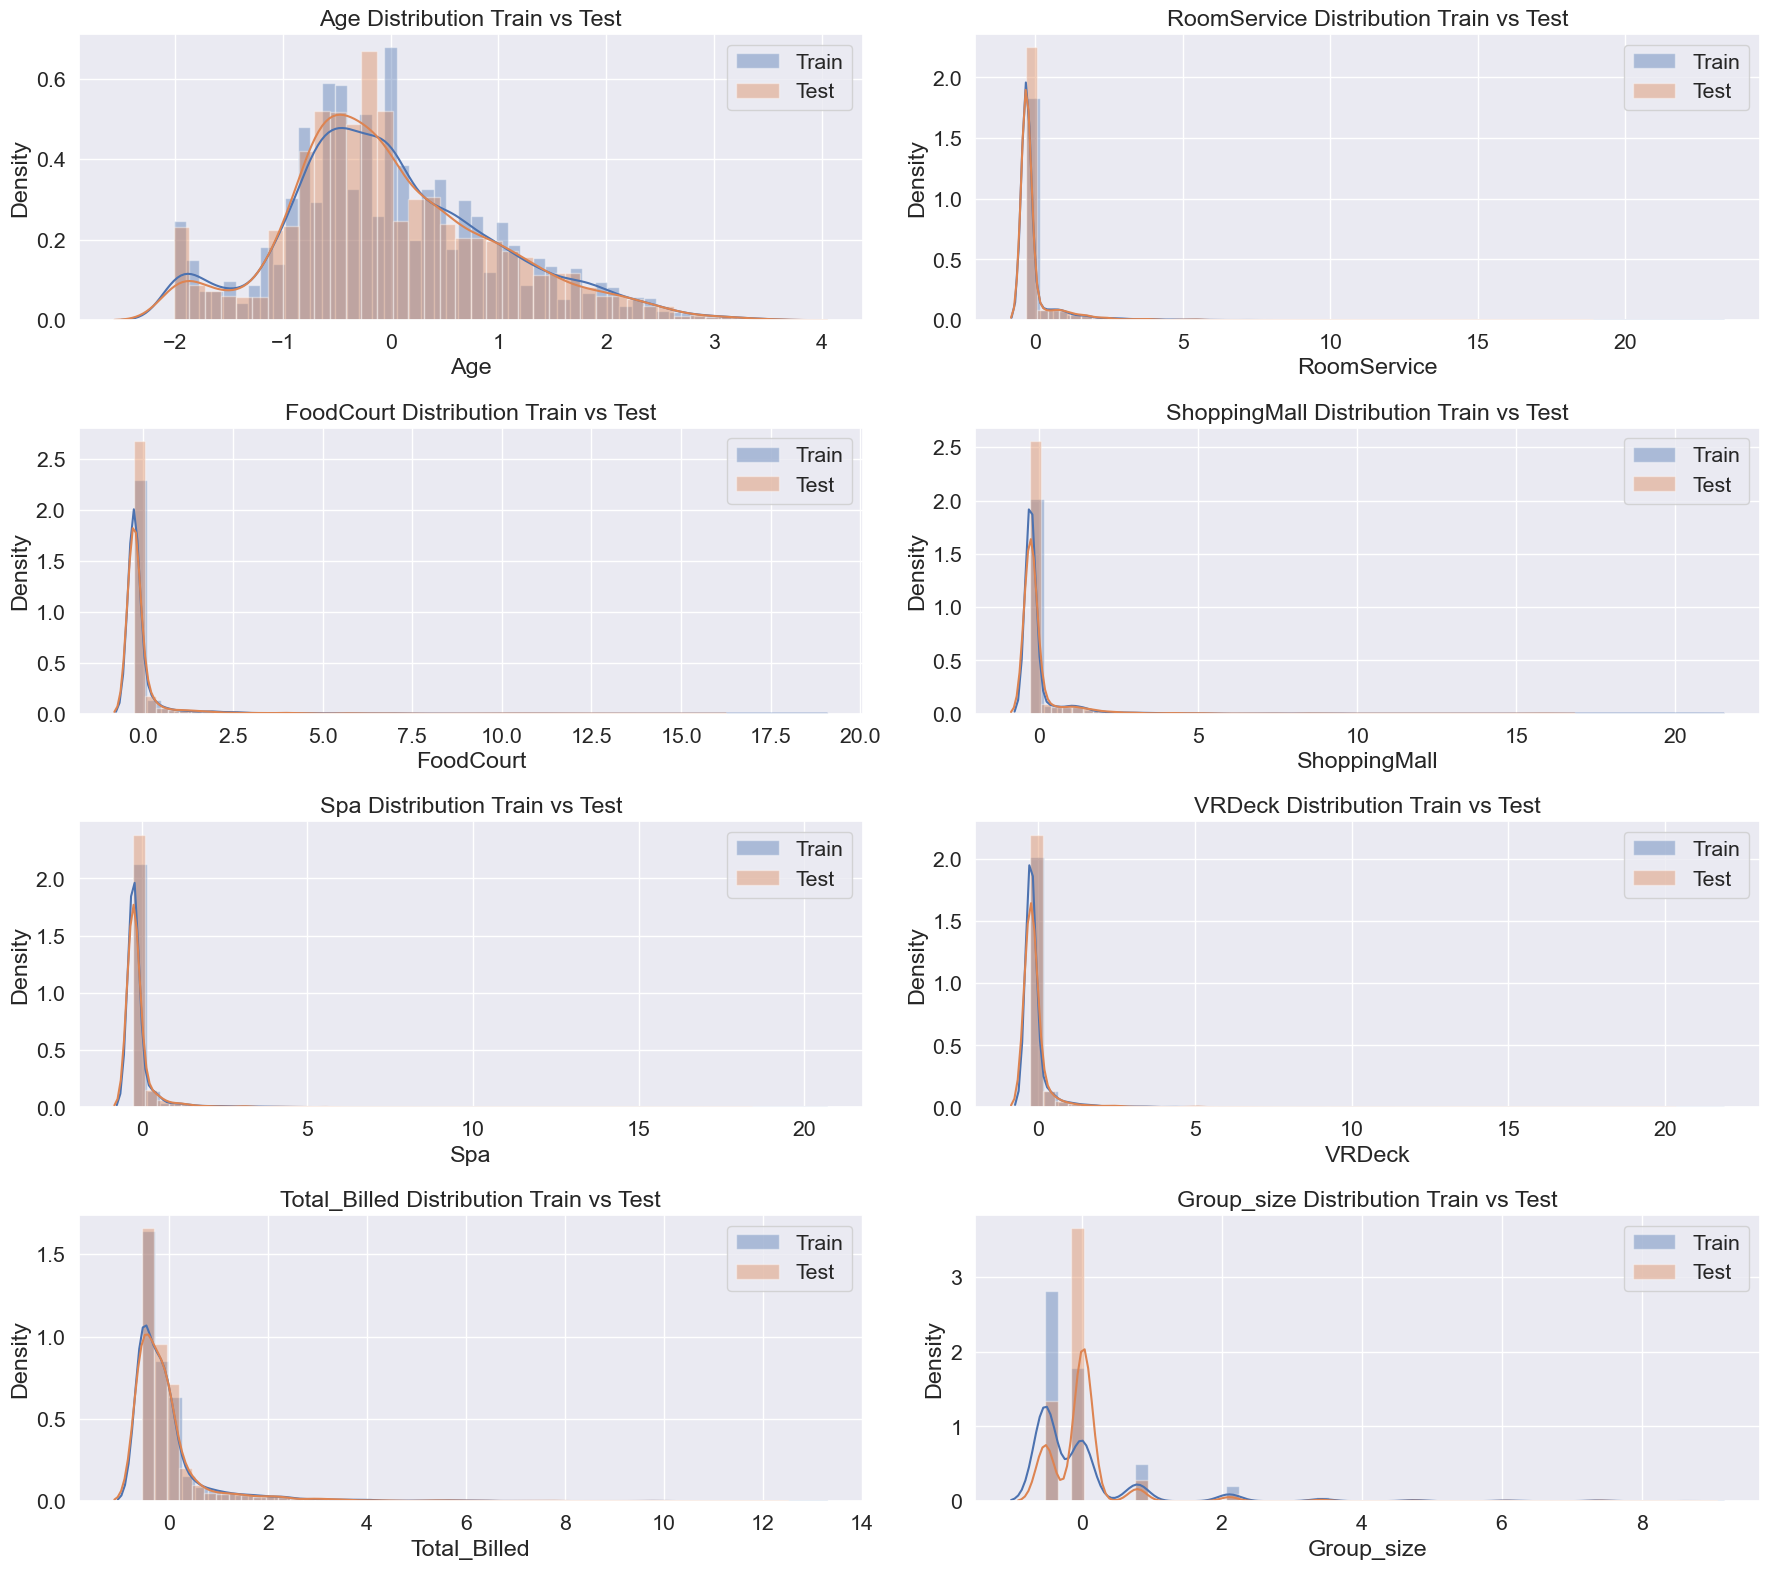

In [160]:
plot_histogram(x_train[numerical_cols], x_test[numerical_cols], target_col)

In [177]:
numerical_cols

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Total_Billed',
 'Group_size']

In [308]:
from sklearn.decomposition import PCA

n_components = 2

pca = PCA(n_components=n_components)

pca_columns = [f'PCA_{i}' for i in range(n_components)]

# Add PCA features to the dataframe
x_train[pca_columns] = pca.fit_transform(x_train[numerical_cols])
x_test[pca_columns] = pca.transform(x_test[numerical_cols])

In [309]:
x_train.drop(['FirstName', 'FamilyName', 'Name'], axis=1, inplace=True)
# x_test.drop(['FirstName', 'FamilyName', 'Name'], axis=1, inplace=True)

In [285]:
x_train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Total_Billed,No_spending,CabinDeck,CabinNum,CabinSide,Group,Group_size,Solo,PCA_0,PCA_1
0,0001_01,1,0,1,0.709437,0,-0.316852,-0.273850,-0.290373,-0.261799,...,-0.551400,1,1,0,1,1,2.920884e-16,0,-0.592611,0.078870
1,0002_01,2,0,1,-0.336717,0,-0.140490,-0.268155,-0.240542,0.239751,...,-0.278040,0,2,0,2,2,-5.200875e-01,1,-0.398836,-0.314722
2,0003_01,1,0,1,2.034566,1,-0.247278,1.989089,-0.290373,5.872822,...,3.304981,0,3,0,2,3,-5.200875e-01,1,5.698120,-0.348625
3,0003_02,1,0,1,0.290975,0,-0.316852,0.538049,0.449122,2.779475,...,1.371034,0,3,0,2,3,7.953616e-01,0,2.271927,-0.036247
4,0004_01,2,0,1,-0.894666,0,-0.316852,-0.273850,-0.290373,-0.261799,...,-0.146189,0,2,1,2,4,-5.200875e-01,1,-0.688170,-0.648121


## Data split
- StandardKFold
- KFold
- sklearn.train_test_split

In [225]:
class Splitter:
    def __init__(self, kfold=True, n_split=5, cat_df=pd.DataFrame(), test_size=0.5):
        self.n_splits = n_split
        self.kfold = kfold
        self.cat_df = cat_df
        self.test_size = test_size
    def split_data(self, x, y, random_state_list):
        if self.kfold == 'skf':
            for random_state in random_state_list:
                kf = StratifiedKFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(x, self.cat_df):
                    x_train, x_val = x.iloc[train_index], x.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield x_train, x_val, y_train, y_val, val_index
        elif self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(x, self.cat_df):
                    x_train, x_val = x.iloc[train_index], x.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield x_train, x_val, y_train, y_val, val_index 
        else:
            for random_state in random_state_list:
                x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=self.test_size, random_state=random_state)
                yield X_train, X_val, y_train, y_val
    

In [275]:
x_train_.shape

(6955, 23)

## Define Model

In [293]:
import lightgbm as lgb
import xgboost as xgb
from xgboost.callback import EarlyStopping
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

class Classifier:
    def __init__(self, n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.models_name = list(self._define_model().keys())
        self.len_models = len(self.models)
        
    def _define_model(self):
        
        xgb_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.05,
            'max_depth': 7,
            'subsample': 1.0,
            'colsample_bytree': 1.0,
            'n_jobs': -1,
            'eval_metric': 'logloss',
            'objective': 'binary:logistic',
            'verbosity': 0,
            'random_state': self.random_state,
        }
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'
        
        lgb_params = {
            'n_estimators': self.n_estimators,
            'max_depth': 7,
            'learning_rate': 0.05,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'binary',
            'metric': 'binary_error',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state
        }
        
        cb_params = {
            'iterations': self.n_estimators,
            'depth': 7,
            'learning_rate': 0.1,
            'l2_leaf_reg': 0.7,
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 65,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'Logloss',
            'loss_function': 'Logloss',
            'task_type': self.device.upper(),
            'random_state': self.random_state,
            'allow_writing_files': False
        }
        
        models = {
            'xgb': xgb.XGBClassifier(**xgb_params),
            'lgb': lgb.LGBMClassifier(**lgb_params),
            'cat': CatBoostClassifier(**cb_params),
            'lr': LogisticRegression(max_iter=500, random_state=self.random_state),
            'rf': RandomForestClassifier(n_estimators=1000, random_state=self.random_state),
            'hgb': HistGradientBoostingClassifier(max_iter=2000, random_state=self.random_state),
            'gbdt': GradientBoostingClassifier(n_estimators=1000, random_state=self.random_state),
            #'svc': SVC(gamma="auto", probability=True),
            #'knn': KNeighborsClassifier(n_neighbors=5),
            'mlp': MLPClassifier(random_state=self.random_state, max_iter=1000),
            'brf': BalancedRandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=self.random_state),
            #'gpc': GaussianProcessClassifier(1.0 * RBF(1.0), random_state=self.random_state),
        }
        
        return models

## Feature Selection

In [294]:
%%time

from sklearn.feature_selection import RFE, RFECV

n_estimators = 200
scoring = 'roc_auc'
min_features_to_select = 10

classifier = Classifier(n_estimators, device='cpu', random_state=0)
models = classifier.models

models_name = [_ for _ in classifier.models_name if ('xgb' in _) or ('lgb' in _) or ('cat' in _)] # ['xgb', 'lgb', 'cat']
trained_models = dict(zip(models_name, ['' for _ in range(classifier.len_models)])) # {'xgb': '', 'lgb': '', 'cat': ''}
unnecessary_features = dict(zip(models_name, [[] for _ in range(classifier.len_models)])) # {'xgb': [], 'lgb': [], 'cat': []}

for name, model in models.items():
    if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
        elimination = RFECV(
            model, 
            step=1,
            min_features_to_select=min_features_to_select,
            cv=2,
            scoring=scoring, 
            n_jobs=-1)
        elimination.fit(x_train_, y_train_)
        
        unnecessary_feature = list(x_train_.columns[~elimination.get_support()])
        idx = np.argmax(elimination.cv_results_['mean_test_score'])
        mean_score = elimination.cv_results_['mean_test_score'][idx]
        std_score = elimination.cv_results_['std_test_score'][idx]
        
        print(f'{name} Best Mean {scoring} {mean_score:.5f} ± {std_score:.5f} | N_STEP {idx}')
        print(f"Best unnecessary_feature: {unnecessary_feature}")
        
        removed_features = [f for i, f in enumerate(x_train_.columns) if elimination.support_[i] == False]
        ranked_features = sorted(zip(x_train_.columns, elimination.ranking_), key=lambda x: x[1])
        removed_features_by_ranking = [f[0] for f in ranked_features if f[0] in removed_features][::-1]
        
        print("Removed features:", removed_features_by_ranking)
        print(f'{"-" * 60}')
        
        trained_models[f'{name}'] = deepcopy(elimination)
        unnecessary_features[f'{name}'].extend(unnecessary_feature)
        
unnecessary_features = np.concatenate([_ for _ in unnecessary_features.values()])
features = np.unique(unnecessary_features, return_counts=True)[0]
counts = np.unique(unnecessary_features, return_counts=True)[1]

drop_features = list(features[counts >= 2])

print("Features recommended to be removed:", drop_features)

xgb Best Mean roc_auc 0.87552 ± 0.00840 | N_STEP 0
Best unnecessary_feature: ['PassengerId', 'Destination', 'Age', 'VIP', 'AgeGroup', 'No_spending', 'CabinNum', 'Group', 'Group_size', 'Solo', 'PCA_0', 'PCA_1']
Removed features: ['Solo', 'Group', 'No_spending', 'AgeGroup', 'VIP', 'Group_size', 'PassengerId', 'PCA_0', 'PCA_1', 'Destination', 'CabinNum', 'Age']
------------------------------------------------------------
lgb Best Mean roc_auc 0.86486 ± 0.00071 | N_STEP 10
Best unnecessary_feature: ['VIP', 'AgeGroup']
Removed features: ['VIP', 'AgeGroup']
------------------------------------------------------------
0:	learn: 0.6226968	total: 154ms	remaining: 30.7s
1:	learn: 0.5731266	total: 173ms	remaining: 17.1s
2:	learn: 0.5341703	total: 186ms	remaining: 12.2s
3:	learn: 0.5056021	total: 198ms	remaining: 9.7s
4:	learn: 0.4837800	total: 212ms	remaining: 8.28s
5:	learn: 0.4639222	total: 231ms	remaining: 7.47s
6:	learn: 0.4503307	total: 250ms	remaining: 6.88s
7:	learn: 0.4372547	total: 269ms

149:	learn: 0.1259918	total: 4.1s	remaining: 1.37s
150:	learn: 0.1250962	total: 4.13s	remaining: 1.34s
151:	learn: 0.1241234	total: 4.15s	remaining: 1.31s
152:	learn: 0.1227857	total: 4.17s	remaining: 1.28s
153:	learn: 0.1218284	total: 4.2s	remaining: 1.25s
154:	learn: 0.1209483	total: 4.23s	remaining: 1.23s
155:	learn: 0.1199971	total: 4.27s	remaining: 1.2s
156:	learn: 0.1191047	total: 4.3s	remaining: 1.18s
157:	learn: 0.1177447	total: 4.33s	remaining: 1.15s
158:	learn: 0.1170903	total: 4.36s	remaining: 1.12s
159:	learn: 0.1164460	total: 4.38s	remaining: 1.09s
160:	learn: 0.1155317	total: 4.41s	remaining: 1.07s
161:	learn: 0.1145773	total: 4.44s	remaining: 1.04s
162:	learn: 0.1136368	total: 4.47s	remaining: 1.01s
163:	learn: 0.1128861	total: 4.5s	remaining: 988ms
164:	learn: 0.1120182	total: 4.53s	remaining: 960ms
165:	learn: 0.1112187	total: 4.55s	remaining: 932ms
166:	learn: 0.1104393	total: 4.58s	remaining: 905ms
167:	learn: 0.1093179	total: 4.61s	remaining: 878ms
168:	learn: 0.108

114:	learn: 0.1661572	total: 3.56s	remaining: 2.63s
115:	learn: 0.1645497	total: 3.59s	remaining: 2.6s
116:	learn: 0.1630730	total: 3.62s	remaining: 2.56s
117:	learn: 0.1620012	total: 3.64s	remaining: 2.53s
118:	learn: 0.1608543	total: 3.66s	remaining: 2.49s
119:	learn: 0.1593055	total: 3.7s	remaining: 2.46s
120:	learn: 0.1587424	total: 3.72s	remaining: 2.43s
121:	learn: 0.1576431	total: 3.75s	remaining: 2.39s
122:	learn: 0.1563548	total: 3.78s	remaining: 2.36s
123:	learn: 0.1556573	total: 3.81s	remaining: 2.33s
124:	learn: 0.1543466	total: 3.83s	remaining: 2.3s
125:	learn: 0.1532055	total: 3.86s	remaining: 2.27s
126:	learn: 0.1521830	total: 3.92s	remaining: 2.25s
127:	learn: 0.1508001	total: 3.95s	remaining: 2.22s
128:	learn: 0.1493713	total: 3.98s	remaining: 2.19s
129:	learn: 0.1484633	total: 4.01s	remaining: 2.16s
130:	learn: 0.1473424	total: 4.04s	remaining: 2.13s
131:	learn: 0.1458120	total: 4.09s	remaining: 2.1s
132:	learn: 0.1443575	total: 4.12s	remaining: 2.07s
133:	learn: 0.14

In [298]:
elimination.cv_results_

{'mean_test_score': array([0.87552475, 0.86143878, 0.85032783, 0.84716572, 0.8467198 ,
        0.84128334, 0.84788174, 0.84517283, 0.84623477, 0.84623477,
        0.84623477, 0.84623477, 0.84623477]),
 'std_test_score': array([0.00839574, 0.00800674, 0.0022813 , 0.00475833, 0.00037287,
        0.00241987, 0.00139261, 0.00426398, 0.00117059, 0.00117059,
        0.00117059, 0.00117059, 0.00117059]),
 'split0_test_score': array([0.86712901, 0.86944551, 0.84804653, 0.84240739, 0.84634693,
        0.84370321, 0.84648913, 0.84090885, 0.84506417, 0.84506417,
        0.84506417, 0.84506417, 0.84506417]),
 'split1_test_score': array([0.88392049, 0.85343204, 0.85260914, 0.85192405, 0.84709267,
        0.83886347, 0.84927434, 0.84943681, 0.84740536, 0.84740536,
        0.84740536, 0.84740536, 0.84740536])}

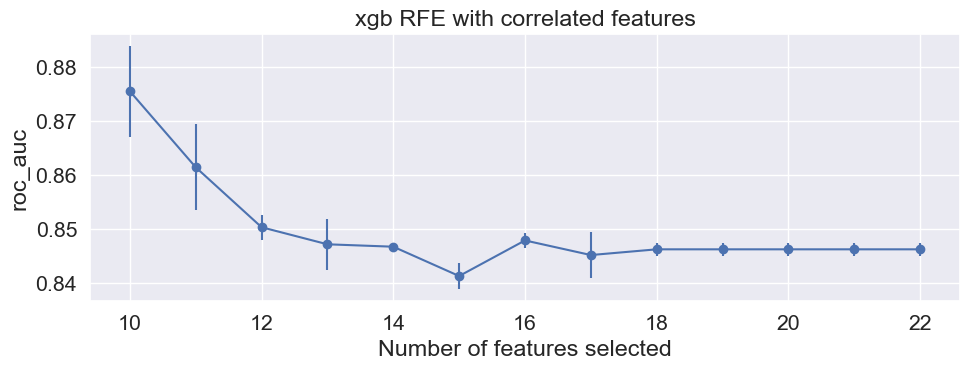

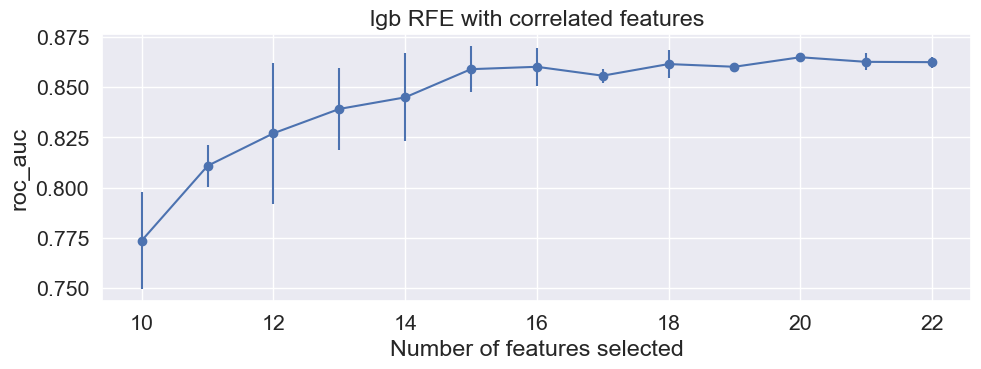

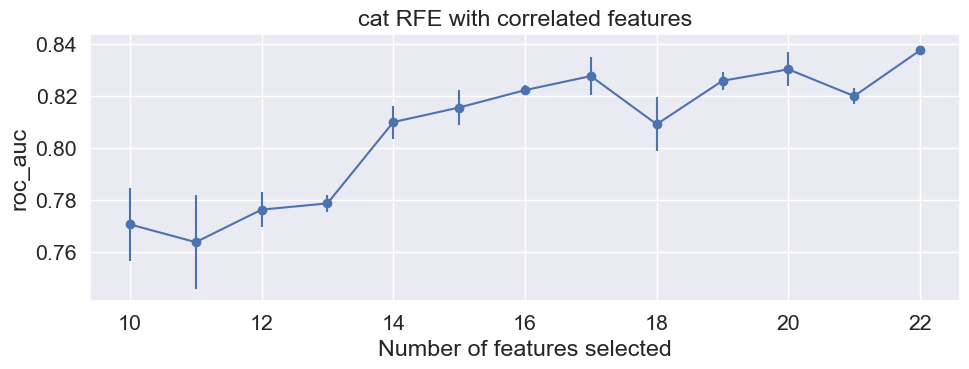

In [300]:
def plot_rfe(elimination, scoring, min_features_to, name):
    n_scores = len(elimination.cv_results_['mean_test_score'])
    plt.figure(figsize=(10, 4))
    plt.xlabel('Number of features selected')
    plt.ylabel(f'{scoring}')
    
    plt.errorbar(
        range(min_features_to_select, n_scores + min_features_to_select),
        elimination.cv_results_['mean_test_score'],
        yerr=elimination.cv_results_['std_test_score'],
        fmt='o-',
    )
    
    plt.title(f'{name} RFE with correlated features')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
for name, elimination in trained_models.items():
    plot_rfe(elimination, scoring, min_features_to_select, name)

In [303]:
x_train_last = x_train_.drop(['PassengerId', 'Destination', 'Age', 'VIP', 'AgeGroup', 'No_spending', 'CabinNum', 'Group', 'Group_size', 'Solo', 'PCA_0', 'PCA_1'], axis=1)

In [310]:
x_train_last.to_csv('E:/workspace/ml-2023/applied-machine-learning-real-world-projects-using-python/spaceship-titanic/train_filtered.csv', index = False)
x_test_last.to_csv('E:/workspace/ml-2023/applied-machine-learning-real-world-projects-using-python/spaceship-titanic/test_filtered.csv', index = False)

## Modeling

In [ ]:
x_train_res = x_train.drop('Transported', axis=1)
y_train_res = x_train[target_col]
n_splits = 10

splitter = Splitter(kfold='skf', cat_df=y_train_res, test_size=0.8)
for x_train_, x_val, y_train_, y_val, val_index in splitter.split_data(x_train_res, y_train_res, random_state_list=[42]):
    print('Data set by train_test_split')
    
    fold = i % n_splits
    m = i // n_splits
    
    